# 🧑‍⚖️ 꿀스테이 RAG - Human-in-the-Loop 평가

이 노트북에서는 ReAct 기반 평가 에이전트와 인간 검증 시스템을 구현합니다.

## 목표
1. ReAct 평가 에이전트 구현
2. 6차원 품질 평가 시스템
3. 인터럽트 기반 Human-in-the-Loop
4. 피드백 수집 및 개선 메커니즘
5. 평가 결과 시각화 및 분석

In [1]:
import os
import sys
from pathlib import Path
from typing import List, Dict, Any, Optional, Tuple, Union
import logging
from dotenv import load_dotenv
from dataclasses import dataclass, field
from enum import Enum
import json
from datetime import datetime
import time
import uuid

# LangChain 관련
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate, PromptTemplate
from langchain_core.output_parsers import StrOutputParser, JsonOutputParser
from langchain_core.documents import Document

# 데이터 처리 및 시각화
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML, clear_output
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed

# 환경변수 로드 (절대 경로 지정)
project_root = Path("/Users/yundoun/Desktop/Project/legal_rag/coolstay_rag")
env_file = project_root / ".env"
load_result = load_dotenv(env_file)
print(f"📝 .env 파일 로드: {load_result} (경로: {env_file})")

# API 키 확인
openai_key = os.getenv("OPENAI_API_KEY", "NOT_FOUND")
tavily_key = os.getenv("TAVILY_API_KEY", "NOT_FOUND")
print(f"🔑 OpenAI API Key: {'설정됨' if openai_key != 'NOT_FOUND' and openai_key.startswith('sk-') else 'NOT_FOUND'}")
print(f"🔑 Tavily API Key: {'설정됨' if tavily_key != 'NOT_FOUND' and tavily_key.startswith('tvly-') else 'NOT_FOUND'}")

# 로깅 설정
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# 한글 폰트 설정 (matplotlib)
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False

print("✅ 라이브러리 import 완료")

📝 .env 파일 로드: True (경로: /Users/yundoun/Desktop/Project/legal_rag/coolstay_rag/.env)
🔑 OpenAI API Key: 설정됨
🔑 Tavily API Key: 설정됨
✅ 라이브러리 import 완료


## 1. 평가 기준 및 데이터 구조 정의

In [2]:
class EvaluationDimension(Enum):
    """평가 차원 정의"""
    RELEVANCE = "relevance"           # 관련성
    ACCURACY = "accuracy"             # 정확성  
    COMPLETENESS = "completeness"     # 완성도
    CLARITY = "clarity"               # 명확성
    USEFULNESS = "usefulness"         # 유용성
    COHERENCE = "coherence"           # 일관성

class EvaluationScore(Enum):
    """평가 점수 (10점 만점)"""
    EXCELLENT = 10    # 매우 우수
    VERY_GOOD = 8     # 우수
    GOOD = 6          # 양호
    FAIR = 4          # 보통
    POOR = 2          # 미흡
    VERY_POOR = 0     # 매우 미흡

class HumanDecision(Enum):
    """인간 평가자 결정"""
    APPROVE = "approve"       # 승인
    REJECT = "reject"         # 거부
    REQUEST_REVISION = "request_revision"  # 수정 요청
    NEED_MORE_INFO = "need_more_info"      # 추가 정보 필요

@dataclass
class DimensionScore:
    """차원별 평가 점수"""
    dimension: EvaluationDimension
    score: int  # 0-10 점
    reasoning: str
    suggestions: List[str] = field(default_factory=list)

@dataclass
class ComprehensiveEvaluation:
    """종합 평가 결과"""
    evaluation_id: str
    question: str
    answer: str
    contributing_domains: List[str]
    
    # AI 평가 결과
    dimension_scores: Dict[EvaluationDimension, DimensionScore]
    overall_score: float  # 0-60 점 (6차원 × 10점)
    ai_recommendation: str
    ai_reasoning: str
    
    # 인간 평가 결과
    human_decision: Optional[HumanDecision] = None
    human_feedback: Optional[str] = None
    human_suggestions: List[str] = field(default_factory=list)
    
    # 메타데이터
    evaluation_timestamp: datetime = field(default_factory=datetime.now)
    evaluator_model: str = "gpt-4o-mini"
    processing_time: float = 0.0

print("✅ 평가 데이터 구조 정의 완료")

✅ 평가 데이터 구조 정의 완료


In [3]:
# LLM 초기화
def initialize_llm():
    try:
        llm = ChatOpenAI(
            model="gpt-4o-mini",
            temperature=0.1,
            api_key=os.getenv("OPENAI_API_KEY")
        )
        
        # 테스트 호출
        test_response = llm.invoke("Hello")
        print(f"✅ LLM 초기화 성공: {llm.model_name}")
        return llm
        
    except Exception as e:
        print(f"❌ LLM 초기화 실패: {e}")
        return None

# LLM 초기화
llm = initialize_llm()

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


✅ LLM 초기화 성공: gpt-4o-mini


## 2. ReAct 평가 에이전트 구현

In [4]:
class ReActEvaluationAgent:
    """ReAct 기반 평가 에이전트"""
    
    def __init__(self, llm: ChatOpenAI):
        self.llm = llm
        
        # ReAct 평가 프롬프트 (Reasoning + Acting)
        self.evaluation_prompt = ChatPromptTemplate.from_template("""
        당신은 꿀스테이 RAG 시스템의 답변을 평가하는 전문 평가자입니다.
        ReAct (Reasoning + Acting) 방식으로 체계적이고 논리적으로 평가해주세요.
        
        **평가 기준 (각 10점 만점, 총 60점):**
        1. **관련성 (Relevance)**: 질문과 답변이 얼마나 관련이 있는가?
        2. **정확성 (Accuracy)**: 제공된 정보가 얼마나 정확하고 사실적인가?
        3. **완성도 (Completeness)**: 질문에 대한 답변이 얼마나 완전한가?
        4. **명확성 (Clarity)**: 답변이 얼마나 이해하기 쉽고 명확한가?
        5. **유용성 (Usefulness)**: 실제 업무에 얼마나 도움이 되는가?
        6. **일관성 (Coherence)**: 답변 내용이 논리적으로 일관되는가?
        
        **평가 대상:**
        - **질문:** {question}
        - **답변:** {answer}
        - **참여 도메인:** {domains}
        - **출처 정보:** {sources}
        
        **ReAct 평가 과정:**
        
        **REASONING 1: 관련성 분석**
        질문의 핵심 내용과 답변의 주제를 비교분석하여 관련성을 평가하겠습니다.
        
        **ACTION 1: 관련성 점수 산정**
        [질문-답변 관련성을 0-10점으로 평가]
        
        **REASONING 2: 정확성 검증**
        답변에 포함된 정보의 사실적 정확성과 출처의 신뢰성을 검토하겠습니다.
        
        **ACTION 2: 정확성 점수 산정**
        [정보의 정확성을 0-10점으로 평가]
        
        **REASONING 3: 완성도 평가**
        질문에서 요구하는 모든 정보가 답변에 포함되었는지 확인하겠습니다.
        
        **ACTION 3: 완성도 점수 산정**
        [답변의 완성도를 0-10점으로 평가]
        
        **REASONING 4: 명확성 검토**
        답변의 구조, 표현, 이해도를 종합적으로 분석하겠습니다.
        
        **ACTION 4: 명확성 점수 산정**
        [답변의 명확성을 0-10점으로 평가]
        
        **REASONING 5: 유용성 판단**
        실제 업무 상황에서의 활용도와 실용적 가치를 평가하겠습니다.
        
        **ACTION 5: 유용성 점수 산정**
        [답변의 유용성을 0-10점으로 평가]
        
        **REASONING 6: 일관성 분석**
        답변 내 논리적 흐름과 내용 간 일관성을 검토하겠습니다.
        
        **ACTION 6: 일관성 점수 산정**
        [답변의 일관성을 0-10점으로 평가]
        
        **FINAL REASONING: 종합 평가**
        6개 차원의 점수를 종합하여 최종 평가와 권장사항을 도출하겠습니다.
        
        **FINAL ACTION: 결과 생성**
        
        다음 JSON 형식으로 평가 결과를 제공하세요:
        {{
            "dimension_scores": {{
                "relevance": {{
                    "score": 0-10,
                    "reasoning": "평가 근거",
                    "suggestions": ["개선 제안1", "개선 제안2"]
                }},
                "accuracy": {{
                    "score": 0-10,
                    "reasoning": "평가 근거",
                    "suggestions": ["개선 제안1", "개선 제안2"]
                }},
                "completeness": {{
                    "score": 0-10,
                    "reasoning": "평가 근거",
                    "suggestions": ["개선 제안1", "개선 제안2"]
                }},
                "clarity": {{
                    "score": 0-10,
                    "reasoning": "평가 근거",
                    "suggestions": ["개선 제안1", "개선 제안2"]
                }},
                "usefulness": {{
                    "score": 0-10,
                    "reasoning": "평가 근거",
                    "suggestions": ["개선 제안1", "개선 제안2"]
                }},
                "coherence": {{
                    "score": 0-10,
                    "reasoning": "평가 근거",
                    "suggestions": ["개선 제안1", "개선 제안2"]
                }}
            }},
            "overall_score": "총점 (0-60)",
            "recommendation": "approve|reject|revise|need_more_info",
            "reasoning": "최종 평가 근거와 권장사항"
        }}
        """)
        
        # 평가 체인 구성
        self.evaluation_chain = (
            self.evaluation_prompt
            | self.llm
            | JsonOutputParser()
        )
    
    def evaluate(self, 
                question: str, 
                answer: str,
                contributing_domains: List[str],
                sources: List[str] = None) -> ComprehensiveEvaluation:
        """종합 평가 수행"""
        
        start_time = time.time()
        evaluation_id = str(uuid.uuid4())
        
        try:
            # 출처 정보 포맷팅
            sources_text = "\n".join(sources) if sources else "출처 정보 없음"
            domains_text = ", ".join(contributing_domains) if contributing_domains else "도메인 정보 없음"
            
            # AI 평가 실행
            result = self.evaluation_chain.invoke({
                "question": question,
                "answer": answer,
                "domains": domains_text,
                "sources": sources_text
            })
            
            # 차원별 점수 객체 생성
            dimension_scores = {}
            total_score = 0
            
            for dim_name, dim_data in result["dimension_scores"].items():
                try:
                    dimension = EvaluationDimension(dim_name)
                    score = int(dim_data["score"])
                    
                    dimension_scores[dimension] = DimensionScore(
                        dimension=dimension,
                        score=score,
                        reasoning=dim_data.get("reasoning", ""),
                        suggestions=dim_data.get("suggestions", [])
                    )
                    
                    total_score += score
                    
                except (ValueError, KeyError) as e:
                    logger.warning(f"차원 {dim_name} 처리 중 오류: {e}")
            
            processing_time = time.time() - start_time
            
            return ComprehensiveEvaluation(
                evaluation_id=evaluation_id,
                question=question,
                answer=answer,
                contributing_domains=contributing_domains,
                dimension_scores=dimension_scores,
                overall_score=float(total_score),
                ai_recommendation=result.get("recommendation", "revise"),
                ai_reasoning=result.get("reasoning", "평가 완료"),
                evaluator_model="gpt-4o-mini",
                processing_time=processing_time
            )
            
        except Exception as e:
            logger.error(f"평가 수행 실패: {e}")
            
            # 기본값으로 평가 객체 생성
            return ComprehensiveEvaluation(
                evaluation_id=evaluation_id,
                question=question,
                answer=answer,
                contributing_domains=contributing_domains,
                dimension_scores={},
                overall_score=30.0,  # 중간 점수
                ai_recommendation="revise",
                ai_reasoning=f"평가 중 오류 발생: {e}",
                processing_time=time.time() - start_time
            )

# ReAct 평가 에이전트 초기화
if llm:
    react_evaluator = ReActEvaluationAgent(llm)
    print("✅ ReAct 평가 에이전트 초기화 완료")
else:
    react_evaluator = None
    print("❌ LLM이 초기화되지 않아 ReAct 평가 에이전트를 생성할 수 없습니다.")

✅ ReAct 평가 에이전트 초기화 완료


## 3. 평가 에이전트 테스트

In [5]:
# 테스트용 질문-답변 샘플
test_samples = [
    {
        "question": "연차 휴가 신청은 어떻게 하나요?",
        "answer": "연차 휴가 신청은 회사 인트라넷의 '휴가신청' 메뉴에서 할 수 있습니다. 최소 3일 전에 신청해야 하며, 팀장의 승인을 받아야 합니다. 연차는 년간 15일이 주어지며, 미사용 연차는 다음 해로 이월되지 않습니다.",
        "domains": ["hr_policy"],
        "sources": ["HR 정책 가이드 - 휴가 관련 섹션"]
    },
    {
        "question": "시스템 아키텍처는 어떻게 구성되나요?",
        "answer": "시스템은 마이크로서비스 아키텍처로 구성됩니다.",  # 불완전한 답변
        "domains": ["architecture"],
        "sources": ["아키텍처 가이드"]
    },
    {
        "question": "코딩 스타일과 배포 프로세스를 알려주세요",
        "answer": "코딩 스타일은 PEP 8을 따르며, 변수명은 snake_case를 사용합니다. 함수명도 소문자와 언더스코어를 사용하고, 클래스명은 CamelCase를 사용합니다. 배포는 CI/CD 파이프라인을 통해 자동화되어 있으며, GitHub Actions를 사용합니다. 테스트 통과 후 스테이징 환경에서 검증한 다음 프로덕션에 배포합니다.",
        "domains": ["tech_policy", "deployment"],
        "sources": ["기술 정책 가이드 - 코딩 표준", "배포 가이드 - CI/CD 프로세스"]
    }
]

def test_react_evaluator(evaluator: ReActEvaluationAgent, samples: List[Dict]):
    """ReAct 평가 에이전트 테스트"""
    
    print("🧑‍⚖️ ReAct 평가 에이전트 테스트 시작\n")
    
    test_results = []
    
    for i, sample in enumerate(samples, 1):
        print(f"📋 테스트 {i}")
        print(f"❓ 질문: {sample['question']}")
        print(f"💬 답변: {sample['answer'][:100]}...")
        print("="*60)
        
        try:
            # 평가 수행
            evaluation = evaluator.evaluate(
                question=sample["question"],
                answer=sample["answer"],
                contributing_domains=sample["domains"],
                sources=sample["sources"]
            )
            
            # 결과 출력
            print(f"\n🎯 평가 결과 (ID: {evaluation.evaluation_id[:8]})")
            print(f"📊 총점: {evaluation.overall_score:.1f}/60점")
            print(f"🤖 AI 권장: {evaluation.ai_recommendation}")
            print(f"⏱️  처리시간: {evaluation.processing_time:.2f}초")
            
            # 차원별 점수
            print(f"\n📏 차원별 평가:")
            for dimension, score_obj in evaluation.dimension_scores.items():
                print(f"   {dimension.value}: {score_obj.score}/10점 - {score_obj.reasoning[:50]}...")
            
            print(f"\n💭 AI 분석: {evaluation.ai_reasoning[:100]}...")
            
            # 테스트 결과 저장
            test_results.append(evaluation)
            
            print(f"\n✅ 평가 완료")
            
        except Exception as e:
            print(f"❌ 평가 실패: {e}")
            logger.error(f"평가 테스트 실패 (샘플 {i}): {e}")
        
        print("\n" + "="*70 + "\n")
    
    return test_results

# ReAct 평가 에이전트 테스트 실행
if react_evaluator:
    evaluation_test_results = test_react_evaluator(react_evaluator, test_samples)
    print(f"✅ ReAct 평가 에이전트 테스트 완료: {len(evaluation_test_results)}개 평가 결과")
else:
    evaluation_test_results = []
    print("❌ ReAct 평가 에이전트가 초기화되지 않아 테스트를 건너뜁니다.")

🧑‍⚖️ ReAct 평가 에이전트 테스트 시작

📋 테스트 1
❓ 질문: 연차 휴가 신청은 어떻게 하나요?
💬 답변: 연차 휴가 신청은 회사 인트라넷의 '휴가신청' 메뉴에서 할 수 있습니다. 최소 3일 전에 신청해야 하며, 팀장의 승인을 받아야 합니다. 연차는 년간 15일이 주어지며, 미사용 연차...


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



🎯 평가 결과 (ID: 96c439f9)
📊 총점: 55.0/60점
🤖 AI 권장: revise
⏱️  처리시간: 12.61초

📏 차원별 평가:
   relevance: 10/10점 - 질문은 연차 휴가 신청 방법에 대한 것이며, 답변은 그에 대한 구체적인 절차를 설명하고 있...
   accuracy: 9/10점 - 답변에 포함된 정보는 일반적인 HR 정책에 부합하며, 출처도 신뢰할 수 있는 HR 정책 가...
   completeness: 8/10점 - 답변은 신청 방법, 신청 기한, 팀장 승인 필요성, 연차 일수에 대한 정보를 포함하고 있으...
   clarity: 9/10점 - 답변은 간결하고 명확하게 작성되어 있어 이해하기 쉽습니다. 그러나 '휴가신청' 메뉴의 위치...
   usefulness: 9/10점 - 답변은 실제 업무에서 연차 휴가를 신청하는 데 필요한 정보를 제공하므로 매우 유용합니다. ...
   coherence: 10/10점 - 답변은 논리적으로 잘 구성되어 있으며, 각 정보가 서로 잘 연결되어 있습니다....

💭 AI 분석: 전반적으로 답변은 질문에 잘 부합하고 유용하지만, 몇 가지 세부사항을 추가하여 완성도를 높일 필요가 있습니다....

✅ 평가 완료


📋 테스트 2
❓ 질문: 시스템 아키텍처는 어떻게 구성되나요?
💬 답변: 시스템은 마이크로서비스 아키텍처로 구성됩니다....


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



🎯 평가 결과 (ID: 279d3496)
📊 총점: 43.0/60점
🤖 AI 권장: revise
⏱️  처리시간: 14.51초

📏 차원별 평가:
   relevance: 8/10점 - 질문은 시스템 아키텍처의 구성에 대한 것이고, 답변은 마이크로서비스 아키텍처라는 특정한 구...
   accuracy: 9/10점 - 마이크로서비스 아키텍처는 현대 시스템 설계에서 널리 사용되는 정확한 정보입니다. 출처인 아...
   completeness: 5/10점 - 답변은 마이크로서비스 아키텍처에 대한 언급만 있고, 시스템 아키텍처의 다른 구성 요소나 특...
   clarity: 7/10점 - 답변은 간결하지만, 마이크로서비스 아키텍처에 대한 추가 설명이 없어서 이해하는 데 다소 부...
   usefulness: 6/10점 - 마이크로서비스 아키텍처에 대한 정보는 유용하지만, 구체적인 적용 사례나 장점이 부족하여 실...
   coherence: 8/10점 - 답변은 논리적으로 일관되지만, 추가적인 설명이 없어서 전체적인 맥락이 다소 부족합니다....

💭 AI 분석: 답변은 관련성과 정확성에서 높은 점수를 받았지만, 완전성과 유용성에서 부족함이 있어 추가적인 정보와 설명이 필요합니다....

✅ 평가 완료


📋 테스트 3
❓ 질문: 코딩 스타일과 배포 프로세스를 알려주세요
💬 답변: 코딩 스타일은 PEP 8을 따르며, 변수명은 snake_case를 사용합니다. 함수명도 소문자와 언더스코어를 사용하고, 클래스명은 CamelCase를 사용합니다. 배포는 CI/CD...


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



🎯 평가 결과 (ID: c54ebfb3)
📊 총점: 54.0/60점
🤖 AI 권장: revise
⏱️  처리시간: 11.65초

📏 차원별 평가:
   relevance: 9/10점 - 질문에서 요구하는 코딩 스타일과 배포 프로세스에 대한 정보가 잘 포함되어 있어 관련성이 높...
   accuracy: 10/10점 - PEP 8, snake_case, CamelCase, CI/CD, GitHub Action...
   completeness: 8/10점 - 코딩 스타일과 배포 프로세스에 대한 기본적인 정보는 포함되어 있으나, 각 요소에 대한 구체...
   clarity: 9/10점 - 답변이 명확하고 이해하기 쉬운 구조로 작성되어 있습니다. 다만, 일부 용어에 대한 간단한 ...
   usefulness: 9/10점 - 실제 업무에서 코딩 스타일과 배포 프로세스는 매우 유용한 정보로, 실무에 직접 적용할 수 ...
   coherence: 9/10점 - 답변의 내용이 논리적으로 잘 연결되어 있으며, 각 요소가 자연스럽게 이어집니다....

💭 AI 분석: 전반적으로 높은 점수를 받았으나, 몇 가지 구체적인 예시와 설명을 추가하면 더욱 완성도 높은 답변이 될 것입니다....

✅ 평가 완료


✅ ReAct 평가 에이전트 테스트 완료: 3개 평가 결과


## 4. Human-in-the-Loop 인터페이스

In [6]:
class HITLInterface:
    """Human-in-the-Loop 평가 인터페이스"""
    
    def __init__(self):
        self.current_evaluation = None
        self.human_feedback_history = []
    
    def create_evaluation_widget(self, evaluation: ComprehensiveEvaluation):
        """평가 위젯 생성"""
        
        self.current_evaluation = evaluation
        
        # 제목
        title = widgets.HTML(
            value=f"<h3>🧑‍⚖️ Human-in-the-Loop 평가</h3>"
                  f"<p><strong>평가 ID:</strong> {evaluation.evaluation_id[:8]}</p>"
        )
        
        # 질문과 답변 표시
        question_widget = widgets.HTML(
            value=f"<div style='background-color: #f0f0f0; padding: 10px; margin: 5px 0;'>"  
                  f"<strong>❓ 질문:</strong><br>{evaluation.question}</div>"
        )
        
        answer_widget = widgets.HTML(
            value=f"<div style='background-color: #e8f4f8; padding: 10px; margin: 5px 0;'>"
                  f"<strong>💬 답변:</strong><br>{evaluation.answer}</div>"
        )
        
        # AI 평가 결과 표시
        ai_score_text = ""
        for dimension, score_obj in evaluation.dimension_scores.items():
            ai_score_text += f"• {dimension.value}: {score_obj.score}/10점<br>"
        
        ai_evaluation_widget = widgets.HTML(
            value=f"<div style='background-color: #fff2e6; padding: 10px; margin: 5px 0;'>"
                  f"<strong>🤖 AI 평가 결과:</strong><br>"
                  f"<strong>총점:</strong> {evaluation.overall_score:.1f}/60점<br>"
                  f"<strong>차원별 점수:</strong><br>{ai_score_text}"
                  f"<strong>AI 권장:</strong> {evaluation.ai_recommendation}<br>"
                  f"<strong>근거:</strong> {evaluation.ai_reasoning[:200]}...</div>"
        )
        
        # 인간 평가 옵션
        decision_widget = widgets.RadioButtons(
            options=[
                ("✅ 승인 (Approve)", "approve"),
                ("❌ 거부 (Reject)", "reject"),
                ("🔄 수정 요청 (Request Revision)", "request_revision"),
                ("ℹ️ 추가 정보 필요 (Need More Info)", "need_more_info")
            ],
            value="approve",
            description="인간 결정:",
            style={'description_width': 'initial'}
        )
        
        # 피드백 텍스트 영역
        feedback_widget = widgets.Textarea(
            value="",
            placeholder="피드백이나 개선 제안을 입력해주세요...",
            description="피드백:",
            layout=widgets.Layout(width='100%', height='100px')
        )
        
        # 제출 버튼
        submit_button = widgets.Button(
            description="평가 제출",
            button_style="success",
            layout=widgets.Layout(width='150px')
        )
        
        # 결과 표시 영역
        result_output = widgets.Output()
        
        # 버튼 클릭 핸들러
        def on_submit(b):
            with result_output:
                clear_output()
                
                # 인간 평가 결과 저장
                human_decision = HumanDecision(decision_widget.value)
                human_feedback = feedback_widget.value.strip()
                
                # 평가 객체 업데이트
                evaluation.human_decision = human_decision
                evaluation.human_feedback = human_feedback
                
                # 피드백 히스토리에 추가
                feedback_record = {
                    "evaluation_id": evaluation.evaluation_id,
                    "question": evaluation.question,
                    "ai_score": evaluation.overall_score,
                    "ai_recommendation": evaluation.ai_recommendation,
                    "human_decision": human_decision.value,
                    "human_feedback": human_feedback,
                    "timestamp": datetime.now()
                }
                
                self.human_feedback_history.append(feedback_record)
                
                # 결과 표시
                print("✅ 인간 평가 완료!")
                print(f"   - 결정: {human_decision.value}")
                print(f"   - AI 점수: {evaluation.overall_score:.1f}/60")
                if human_feedback:
                    print(f"   - 피드백: {human_feedback[:100]}...")
                print(f"   - 평가 ID: {evaluation.evaluation_id}")
                
                # AI와 인간 평가 비교
                ai_approve = evaluation.ai_recommendation in ["approve"]
                human_approve = human_decision in [HumanDecision.APPROVE]
                
                if ai_approve == human_approve:
                    print("   - 🤝 AI와 인간 평가 일치")
                else:
                    print("   - 🤔 AI와 인간 평가 불일치 - 학습 기회")
        
        submit_button.on_click(on_submit)
        
        # 전체 위젯 구성
        full_widget = widgets.VBox([
            title,
            question_widget,
            answer_widget,
            ai_evaluation_widget,
            decision_widget,
            feedback_widget,
            submit_button,
            result_output
        ])
        
        return full_widget
    
    def get_feedback_summary(self) -> Dict[str, Any]:
        """피드백 히스토리 요약"""
        if not self.human_feedback_history:
            return {"message": "아직 피드백 히스토리가 없습니다."}
        
        df = pd.DataFrame(self.human_feedback_history)
        
        summary = {
            "total_evaluations": len(df),
            "decision_distribution": df["human_decision"].value_counts().to_dict(),
            "average_ai_score": df["ai_score"].mean(),
            "agreement_rate": 0.0  # AI-Human 일치율은 별도 계산
        }
        
        return summary
    
    def create_feedback_dashboard(self):
        """피드백 대시보드 생성"""
        if not self.human_feedback_history:
            return widgets.HTML(value="<p>아직 수집된 피드백이 없습니다.</p>")
        
        summary = self.get_feedback_summary()
        
        dashboard_html = f"""
        <div style='background-color: #f5f5f5; padding: 15px; border-radius: 5px;'>
            <h3>📊 피드백 대시보드</h3>
            <p><strong>총 평가 수:</strong> {summary['total_evaluations']}건</p>
            <p><strong>평균 AI 점수:</strong> {summary['average_ai_score']:.1f}/60점</p>
            <p><strong>인간 결정 분포:</strong></p>
            <ul>
        """
        
        for decision, count in summary["decision_distribution"].items():
            percentage = (count / summary["total_evaluations"]) * 100
            dashboard_html += f"<li>{decision}: {count}건 ({percentage:.1f}%)</li>"
        
        dashboard_html += "</ul></div>"
        
        return widgets.HTML(value=dashboard_html)

# HITL 인터페이스 초기화
hitl_interface = HITLInterface()
print("✅ Human-in-the-Loop 인터페이스 초기화 완료")

✅ Human-in-the-Loop 인터페이스 초기화 완료


## 5. HITL 평가 인터페이스 테스트

In [ ]:
# HITL 인터페이스 테스트
if evaluation_test_results:
    print("🧑‍⚖️ Human-in-the-Loop 평가 인터페이스 테스트")
    print("\n첫 번째 평가 결과로 HITL 인터페이스를 생성합니다:")
    
    # 첫 번째 평가 결과 사용
    sample_evaluation = evaluation_test_results[0]
    
    # HITL 위젯 생성
    hitl_widget = hitl_interface.create_evaluation_widget(sample_evaluation)
    
    print("\n👆 위의 인터페이스에서 평가를 수행해보세요!")
    print("   1. AI 평가 결과를 검토하세요")
    print("   2. 인간 결정을 선택하세요")
    print("   3. 필요시 피드백을 입력하세요")
    print("   4. '평가 제출' 버튼을 클릭하세요")
    
    display(hitl_widget)
    
else:
    print("❌ 테스트할 평가 결과가 없습니다. 먼저 ReAct 평가 에이전트를 실행해주세요.")

🧑‍⚖️ Human-in-the-Loop 평가 인터페이스 테스트

첫 번째 평가 결과로 HITL 인터페이스를 생성합니다:

👆 위의 인터페이스에서 평가를 수행해보세요!
   1. AI 평가 결과를 검토하세요
   2. 인간 결정을 선택하세요
   3. 필요시 피드백을 입력하세요
   4. '평가 제출' 버튼을 클릭하세요


In [8]:
# 피드백 대시보드 표시 (평가 후)
def show_feedback_dashboard():
    """피드백 대시보드 표시"""
    print("📊 피드백 수집 현황")
    
    dashboard_widget = hitl_interface.create_feedback_dashboard()
    display(dashboard_widget)
    
    # 상세 히스토리
    if hitl_interface.human_feedback_history:
        print("\n📋 상세 피드백 히스토리:")
        
        df = pd.DataFrame(hitl_interface.human_feedback_history)
        
        # 주요 컬럼만 표시
        display_df = df[[
            'evaluation_id', 'ai_score', 'ai_recommendation', 
            'human_decision', 'timestamp'
        ]].copy()
        
        # evaluation_id 축약
        display_df['evaluation_id'] = display_df['evaluation_id'].str[:8]
        display_df['timestamp'] = display_df['timestamp'].dt.strftime('%H:%M:%S')
        
        display(display_df)
    else:
        print("아직 수집된 피드백이 없습니다.")

# 대시보드 생성 버튼
dashboard_button = widgets.Button(
    description="📊 피드백 대시보드 보기",
    button_style="info",
    layout=widgets.Layout(width='200px')
)

def on_dashboard_click(b):
    show_feedback_dashboard()

dashboard_button.on_click(on_dashboard_click)

print("\n👇 평가를 완료한 후 아래 버튼을 클릭하여 피드백 현황을 확인하세요:")
display(dashboard_button)


👇 평가를 완료한 후 아래 버튼을 클릭하여 피드백 현황을 확인하세요:


Button(button_style='info', description='📊 피드백 대시보드 보기', layout=Layout(width='200px'), style=ButtonStyle())

HTML(value="\n        <div style='background-color: #f5f5f5; padding: 15px; border-radius: 5px;'>\n           …

,evaluation_id,ai_score,ai_recommendation,human_decision,timestamp
0,96c439f9,55.0,revise,approve,13:42:15
1,96c439f9,55.0,revise,request_revision,13:42:20
2,96c439f9,55.0,revise,request_revision,13:42:24


## 6. 평가 결과 분석 및 시각화

In [9]:
class EvaluationAnalyzer:
    """평가 결과 분석 및 시각화"""
    
    def __init__(self):
        self.evaluations = []
    
    def add_evaluation(self, evaluation: ComprehensiveEvaluation):
        """평가 결과 추가"""
        self.evaluations.append(evaluation)
    
    def add_evaluations(self, evaluations: List[ComprehensiveEvaluation]):
        """여러 평가 결과 추가"""
        self.evaluations.extend(evaluations)
    
    def create_evaluation_dataframe(self) -> pd.DataFrame:
        """평가 결과를 DataFrame으로 변환"""
        if not self.evaluations:
            return pd.DataFrame()
        
        data = []
        
        for eval_obj in self.evaluations:
            row = {
                'evaluation_id': eval_obj.evaluation_id[:8],
                'question': eval_obj.question[:50] + '...' if len(eval_obj.question) > 50 else eval_obj.question,
                'answer_length': len(eval_obj.answer),
                'domains': ', '.join(eval_obj.contributing_domains),
                'overall_score': eval_obj.overall_score,
                'ai_recommendation': eval_obj.ai_recommendation,
                'human_decision': eval_obj.human_decision.value if eval_obj.human_decision else None,
                'processing_time': eval_obj.processing_time,
                'timestamp': eval_obj.evaluation_timestamp
            }
            
            # 차원별 점수 추가
            for dimension in EvaluationDimension:
                if dimension in eval_obj.dimension_scores:
                    row[f'{dimension.value}_score'] = eval_obj.dimension_scores[dimension].score
                else:
                    row[f'{dimension.value}_score'] = 0
            
            data.append(row)
        
        return pd.DataFrame(data)
    
    def plot_dimension_scores(self, figsize=(12, 8)):
        """차원별 점수 분포 시각화"""
        df = self.create_evaluation_dataframe()
        if df.empty:
            print("시각화할 데이터가 없습니다.")
            return
        
        # 차원별 점수 컬럼 추출
        dimension_cols = [f'{dim.value}_score' for dim in EvaluationDimension]
        dimension_data = df[dimension_cols]
        
        # 컬럼명 정리
        dimension_data.columns = [col.replace('_score', '') for col in dimension_data.columns]
        
        plt.figure(figsize=figsize)
        
        # 박스 플롯
        plt.subplot(2, 2, 1)
        dimension_data.boxplot(ax=plt.gca())
        plt.title('Dimension Scores Distribution')
        plt.ylabel('Score (0-10)')
        plt.xticks(rotation=45)
        
        # 평균 점수 바 차트
        plt.subplot(2, 2, 2)
        mean_scores = dimension_data.mean()
        plt.bar(mean_scores.index, mean_scores.values)
        plt.title('Average Dimension Scores')
        plt.ylabel('Average Score')
        plt.xticks(rotation=45)
        plt.ylim(0, 10)
        
        # 전체 점수 분포
        plt.subplot(2, 2, 3)
        plt.hist(df['overall_score'], bins=10, alpha=0.7, edgecolor='black')
        plt.title('Overall Score Distribution')
        plt.xlabel('Overall Score (0-60)')
        plt.ylabel('Frequency')
        
        # AI 권장사항 분포
        plt.subplot(2, 2, 4)
        recommendation_counts = df['ai_recommendation'].value_counts()
        plt.pie(recommendation_counts.values, labels=recommendation_counts.index, autopct='%1.1f%%')
        plt.title('AI Recommendation Distribution')
        
        plt.tight_layout()
        plt.show()
    
    def plot_ai_human_agreement(self, figsize=(10, 6)):
        """AI-인간 평가 일치도 분석"""
        df = self.create_evaluation_dataframe()
        if df.empty or df['human_decision'].isna().all():
            print("인간 평가 데이터가 없어 일치도를 분석할 수 없습니다.")
            return
        
        # 인간 평가가 있는 데이터만 필터링
        human_evaluated = df.dropna(subset=['human_decision'])
        
        if human_evaluated.empty:
            print("인간 평가 데이터가 없습니다.")
            return
        
        plt.figure(figsize=figsize)
        
        # AI 권장 vs 인간 결정 매트릭스
        plt.subplot(1, 2, 1)
        agreement_matrix = pd.crosstab(
            human_evaluated['ai_recommendation'], 
            human_evaluated['human_decision']
        )
        sns.heatmap(agreement_matrix, annot=True, fmt='d', cmap='Blues')
        plt.title('AI Recommendation vs Human Decision')
        plt.xlabel('Human Decision')
        plt.ylabel('AI Recommendation')
        
        # 점수 vs 인간 결정
        plt.subplot(1, 2, 2)
        for decision in human_evaluated['human_decision'].unique():
            decision_scores = human_evaluated[human_evaluated['human_decision'] == decision]['overall_score']
            plt.hist(decision_scores, alpha=0.7, label=decision, bins=5)
        
        plt.title('Score Distribution by Human Decision')
        plt.xlabel('Overall Score')
        plt.ylabel('Frequency')
        plt.legend()
        
        plt.tight_layout()
        plt.show()
    
    def generate_analysis_report(self) -> str:
        """분석 보고서 생성"""
        df = self.create_evaluation_dataframe()
        if df.empty:
            return "분석할 데이터가 없습니다."
        
        report = []
        report.append("📊 평가 결과 분석 보고서")
        report.append("=" * 40)
        
        # 기본 통계
        report.append(f"\n📈 기본 통계:")
        report.append(f"   - 총 평가 수: {len(df)}개")
        report.append(f"   - 평균 전체 점수: {df['overall_score'].mean():.1f}/60점")
        report.append(f"   - 점수 표준편차: {df['overall_score'].std():.1f}")
        report.append(f"   - 평균 처리 시간: {df['processing_time'].mean():.2f}초")
        
        # 차원별 평균 점수
        report.append(f"\n🎯 차원별 평균 점수:")
        dimension_cols = [f'{dim.value}_score' for dim in EvaluationDimension]
        for col in dimension_cols:
            if col in df.columns:
                dim_name = col.replace('_score', '')
                avg_score = df[col].mean()
                report.append(f"   - {dim_name}: {avg_score:.1f}/10점")
        
        # AI 권장사항 분포
        report.append(f"\n🤖 AI 권장사항 분포:")
        for rec, count in df['ai_recommendation'].value_counts().items():
            percentage = (count / len(df)) * 100
            report.append(f"   - {rec}: {count}개 ({percentage:.1f}%)")
        
        # 인간 평가 분포 (있는 경우)
        human_evaluated = df.dropna(subset=['human_decision'])
        if not human_evaluated.empty:
            report.append(f"\n🧑‍⚖️ 인간 평가 분포 ({len(human_evaluated)}개):")
            for decision, count in human_evaluated['human_decision'].value_counts().items():
                percentage = (count / len(human_evaluated)) * 100
                report.append(f"   - {decision}: {count}개 ({percentage:.1f}%)")
        
        return "\n".join(report)

# 평가 분석기 초기화 및 테스트 데이터 추가
analyzer = EvaluationAnalyzer()

if evaluation_test_results:
    analyzer.add_evaluations(evaluation_test_results)
    print(f"✅ 평가 분석기 초기화 완료: {len(evaluation_test_results)}개 평가 결과 추가")
else:
    print("✅ 평가 분석기 초기화 완료: 분석할 데이터 없음")

✅ 평가 분석기 초기화 완료: 3개 평가 결과 추가


📊 평가 결과 분석 및 시각화

📊 평가 결과 분석 보고서

📈 기본 통계:
   - 총 평가 수: 3개
   - 평균 전체 점수: 50.7/60점
   - 점수 표준편차: 6.7
   - 평균 처리 시간: 12.92초

🎯 차원별 평균 점수:
   - relevance: 9.0/10점
   - accuracy: 9.3/10점
   - completeness: 7.0/10점
   - clarity: 8.3/10점
   - usefulness: 8.0/10점
   - coherence: 9.0/10점

🤖 AI 권장사항 분포:
   - revise: 3개 (100.0%)

🧑‍⚖️ 인간 평가 분포 (1개):
   - request_revision: 1개 (100.0%)

📈 시각화 차트들:


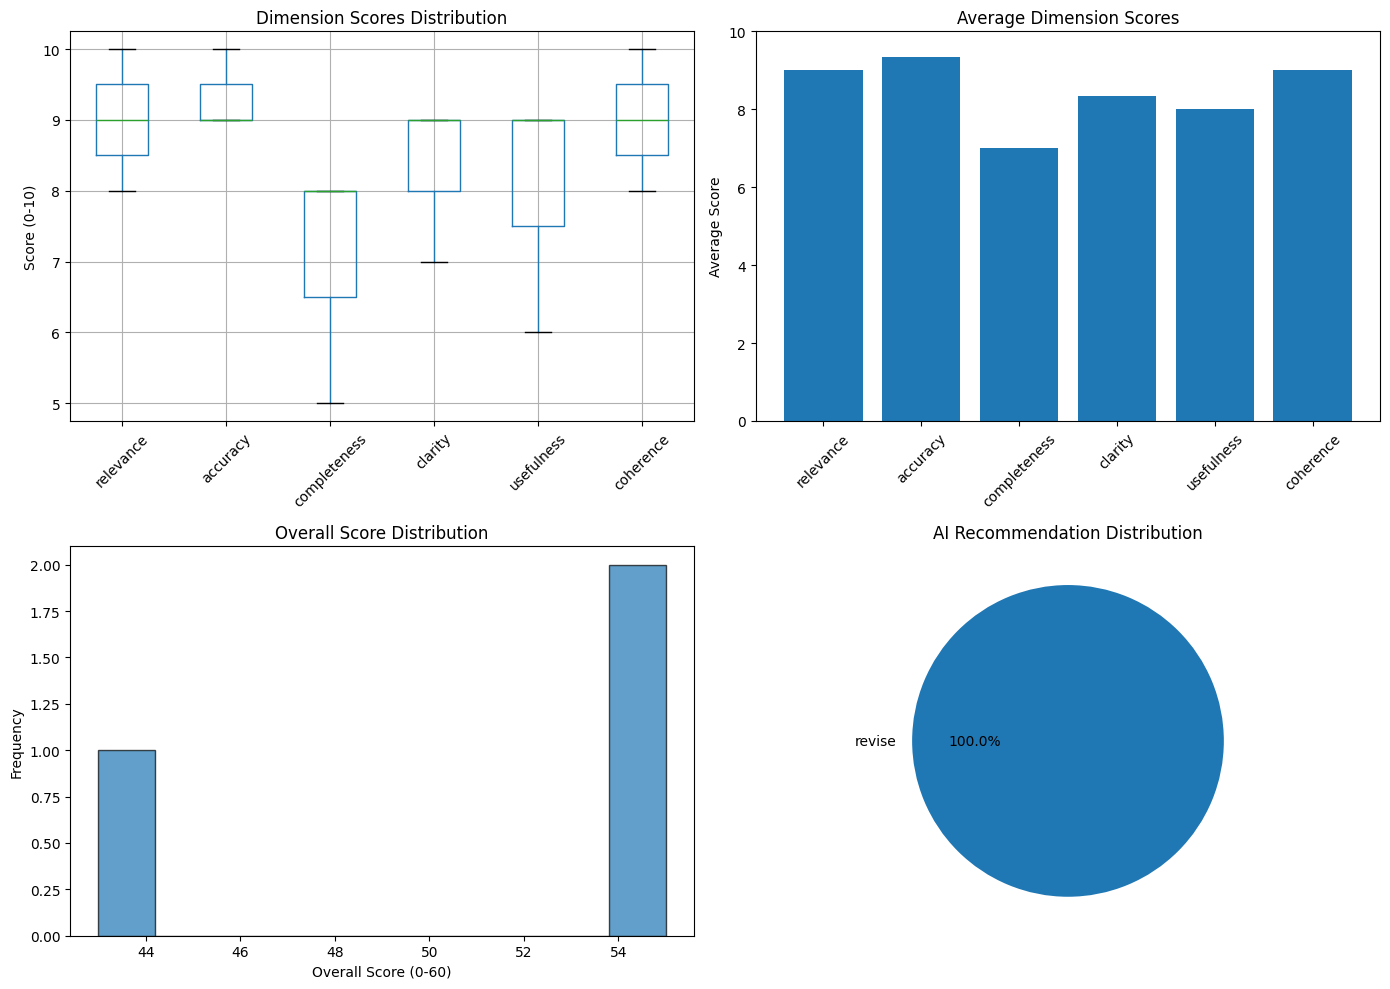


📋 평가 결과 상세 데이터:


,evaluation_id,question,overall_score,ai_recommendation,relevance_score,accuracy_score,completeness_score
0,96c439f9,연차 휴가 신청은 어떻게 하나요?,55.0,revise,10,9,8
1,279d3496,시스템 아키텍처는 어떻게 구성되나요?,43.0,revise,8,9,5
2,c54ebfb3,코딩 스타일과 배포 프로세스를 알려주세요,54.0,revise,9,10,8


In [10]:
# 평가 결과 분석 및 시각화
if evaluation_test_results:
    print("📊 평가 결과 분석 및 시각화\n")
    
    # 분석 보고서 출력
    report = analyzer.generate_analysis_report()
    print(report)
    
    print("\n" + "="*50)
    print("📈 시각화 차트들:")
    
    # 차원별 점수 시각화
    analyzer.plot_dimension_scores(figsize=(14, 10))
    
    # DataFrame 표시
    print("\n📋 평가 결과 상세 데이터:")
    eval_df = analyzer.create_evaluation_dataframe()
    
    # 주요 컬럼만 표시
    display_columns = [
        'evaluation_id', 'question', 'overall_score', 'ai_recommendation',
        'relevance_score', 'accuracy_score', 'completeness_score'
    ]
    
    display_df = eval_df[display_columns]
    display(display_df)
    
else:
    print("❌ 분석할 평가 결과가 없습니다.")
    print("   먼저 ReAct 평가 에이전트 테스트를 실행해주세요.")

## 7. 통합 HITL 워크플로우

In [11]:
class IntegratedHITLWorkflow:
    """통합 HITL 워크플로우 관리자"""
    
    def __init__(self, 
                 react_evaluator: ReActEvaluationAgent,
                 hitl_interface: HITLInterface,
                 analyzer: EvaluationAnalyzer):
        
        self.react_evaluator = react_evaluator
        self.hitl_interface = hitl_interface
        self.analyzer = analyzer
    
    def evaluate_with_hitl(self, 
                          question: str,
                          answer: str,
                          contributing_domains: List[str],
                          sources: List[str] = None,
                          auto_approve_threshold: float = 50.0) -> ComprehensiveEvaluation:
        """HITL를 포함한 완전한 평가 워크플로우"""
        
        print(f"🔄 통합 HITL 평가 시작...")
        
        # 1단계: AI 평가 수행
        print("1️⃣ AI 평가 수행 중...")
        evaluation = self.react_evaluator.evaluate(
            question=question,
            answer=answer,
            contributing_domains=contributing_domains,
            sources=sources
        )
        
        print(f"   AI 평가 완료: {evaluation.overall_score:.1f}/60점 ({evaluation.ai_recommendation})")
        
        # 2단계: 자동 승인 여부 판단
        if (evaluation.overall_score >= auto_approve_threshold and 
            evaluation.ai_recommendation == "approve"):
            
            print(f"✅ 자동 승인 (점수 {evaluation.overall_score:.1f} >= {auto_approve_threshold})")
            evaluation.human_decision = HumanDecision.APPROVE
            evaluation.human_feedback = "자동 승인 (AI 평가 기준 충족)"
            
        else:
            print(f"⏸️  인간 검토 필요 (점수: {evaluation.overall_score:.1f}, AI 권장: {evaluation.ai_recommendation})")
            
            # 3단계: HITL 인터페이스 제공
            print("\n2️⃣ Human-in-the-Loop 평가:")
            hitl_widget = self.hitl_interface.create_evaluation_widget(evaluation)
            display(hitl_widget)
            
            print("   👆 위의 인터페이스에서 인간 평가를 완료해주세요.")
        
        # 4단계: 분석기에 결과 추가
        self.analyzer.add_evaluation(evaluation)
        
        print(f"\n✅ 통합 평가 완료 (ID: {evaluation.evaluation_id[:8]})")
        return evaluation
    
    def batch_evaluate(self, 
                      samples: List[Dict],
                      auto_approve_threshold: float = 50.0) -> List[ComprehensiveEvaluation]:
        """배치 평가 수행"""
        
        print(f"🔄 배치 HITL 평가 시작: {len(samples)}개 샘플")
        
        results = []
        auto_approved = 0
        
        for i, sample in enumerate(samples, 1):
            print(f"\n📋 샘플 {i}/{len(samples)}: {sample['question'][:50]}...")
            
            try:
                evaluation = self.evaluate_with_hitl(
                    question=sample["question"],
                    answer=sample["answer"],
                    contributing_domains=sample["domains"],
                    sources=sample.get("sources", []),
                    auto_approve_threshold=auto_approve_threshold
                )
                
                results.append(evaluation)
                
                if (evaluation.human_decision == HumanDecision.APPROVE and
                    "자동 승인" in (evaluation.human_feedback or "")):
                    auto_approved += 1
                
            except Exception as e:
                print(f"   ❌ 평가 실패: {e}")
                logger.error(f"배치 평가 실패 (샘플 {i}): {e}")
        
        print(f"\n🎉 배치 평가 완료!")
        print(f"   - 총 평가: {len(results)}개")
        print(f"   - 자동 승인: {auto_approved}개")
        print(f"   - 인간 검토: {len(results) - auto_approved}개")
        
        return results
    
    def generate_workflow_report(self) -> str:
        """워크플로우 보고서 생성"""
        analysis_report = self.analyzer.generate_analysis_report()
        feedback_summary = self.hitl_interface.get_feedback_summary()
        
        report = []
        report.append("🧑‍⚖️ 통합 HITL 워크플로우 보고서")
        report.append("=" * 50)
        
        report.append("\n" + analysis_report)
        
        if feedback_summary.get("total_evaluations", 0) > 0:
            report.append(f"\n\n👥 인간 피드백 요약:")
            report.append(f"   - 인간 평가 수: {feedback_summary['total_evaluations']}개")
            
            if "decision_distribution" in feedback_summary:
                for decision, count in feedback_summary["decision_distribution"].items():
                    percentage = (count / feedback_summary["total_evaluations"]) * 100
                    report.append(f"   - {decision}: {count}개 ({percentage:.1f}%)")
        
        return "\n".join(report)

# 통합 HITL 워크플로우 초기화
if all([react_evaluator, hitl_interface, analyzer]):
    integrated_hitl = IntegratedHITLWorkflow(
        react_evaluator=react_evaluator,
        hitl_interface=hitl_interface,
        analyzer=analyzer
    )
    print("✅ 통합 HITL 워크플로우 초기화 완료")
else:
    integrated_hitl = None
    missing = []
    if not react_evaluator: missing.append("ReAct 평가 에이전트")
    if not hitl_interface: missing.append("HITL 인터페이스")
    if not analyzer: missing.append("분석기")
    print(f"❌ 통합 HITL 워크플로우를 초기화할 수 없습니다. 누락: {', '.join(missing)}")

✅ 통합 HITL 워크플로우 초기화 완료


## 8. 통합 HITL 워크플로우 테스트

In [12]:
# 통합 HITL 워크플로우 테스트
if integrated_hitl:
    print("🚀 통합 HITL 워크플로우 테스트")
    
    # 테스트용 새로운 샘플
    workflow_test_sample = {
        "question": "회사의 개발 프로세스와 코딩 표준을 알려주세요",
        "answer": "꿀스테이의 개발 프로세스는 애자일 방법론을 기반으로 합니다. 2주 단위 스프린트로 진행하며, 매일 스탠드업 미팅을 통해 진행 상황을 공유합니다. 코딩 표준으로는 PEP 8을 따르며, 모든 함수와 클래스에 docstring을 작성해야 합니다. 코드 리뷰는 필수이며, 최소 2명의 승인을 받아야 머지 가능합니다. 테스트 커버리지는 80% 이상을 유지해야 합니다.",
        "domains": ["development", "tech_policy"],
        "sources": ["개발 프로세스 가이드", "기술 정책 문서"]
    }
    
    print("\n📋 테스트 샘플:")
    print(f"❓ 질문: {workflow_test_sample['question']}")
    print(f"💬 답변: {workflow_test_sample['answer'][:100]}...")
    print(f"🏷️  도메인: {', '.join(workflow_test_sample['domains'])}")
    
    print("\n" + "="*60)
    
    # 통합 워크플로우 실행
    try:
        workflow_result = integrated_hitl.evaluate_with_hitl(
            question=workflow_test_sample["question"],
            answer=workflow_test_sample["answer"],
            contributing_domains=workflow_test_sample["domains"],
            sources=workflow_test_sample["sources"],
            auto_approve_threshold=45.0  # 낮은 임계값으로 HITL 테스트
        )
        
        print(f"\n✅ 워크플로우 테스트 완료!")
        
    except Exception as e:
        print(f"❌ 워크플로우 테스트 실패: {e}")
        logger.error(f"통합 HITL 워크플로우 테스트 실패: {e}")
else:
    print("❌ 통합 HITL 워크플로우가 초기화되지 않아 테스트를 건너뜁니다.")

🚀 통합 HITL 워크플로우 테스트

📋 테스트 샘플:
❓ 질문: 회사의 개발 프로세스와 코딩 표준을 알려주세요
💬 답변: 꿀스테이의 개발 프로세스는 애자일 방법론을 기반으로 합니다. 2주 단위 스프린트로 진행하며, 매일 스탠드업 미팅을 통해 진행 상황을 공유합니다. 코딩 표준으로는 PEP 8을 따르며...
🏷️  도메인: development, tech_policy

🔄 통합 HITL 평가 시작...
1️⃣ AI 평가 수행 중...


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   AI 평가 완료: 58.0/60점 (approve)
✅ 자동 승인 (점수 58.0 >= 45.0)

✅ 통합 평가 완료 (ID: 086503b3)

✅ 워크플로우 테스트 완료!


In [13]:
# 최종 워크플로우 보고서
if integrated_hitl:
    print("📊 최종 HITL 워크플로우 보고서\n")
    
    final_report = integrated_hitl.generate_workflow_report()
    print(final_report)
    
    print("\n" + "="*50)
    print("🎯 HITL 시스템 요약:")
    print("   ✅ ReAct 기반 AI 평가 (6차원, 60점 만점)")
    print("   ✅ 인터럽트 기반 인간 검증")
    print("   ✅ 자동 승인 임계값 설정")
    print("   ✅ 피드백 수집 및 분석")
    print("   ✅ 실시간 대시보드 제공")
    print("   ✅ AI-인간 평가 일치도 추적")
else:
    print("❌ 통합 워크플로우가 초기화되지 않아 보고서를 생성할 수 없습니다.")

📊 최종 HITL 워크플로우 보고서

🧑‍⚖️ 통합 HITL 워크플로우 보고서

📊 평가 결과 분석 보고서

📈 기본 통계:
   - 총 평가 수: 4개
   - 평균 전체 점수: 52.5/60점
   - 점수 표준편차: 6.6
   - 평균 처리 시간: 12.58초

🎯 차원별 평균 점수:
   - relevance: 9.2/10점
   - accuracy: 9.5/10점
   - completeness: 7.5/10점
   - clarity: 8.5/10점
   - usefulness: 8.5/10점
   - coherence: 9.2/10점

🤖 AI 권장사항 분포:
   - revise: 3개 (75.0%)
   - approve: 1개 (25.0%)

🧑‍⚖️ 인간 평가 분포 (2개):
   - request_revision: 1개 (50.0%)
   - approve: 1개 (50.0%)


👥 인간 피드백 요약:
   - 인간 평가 수: 3개
   - request_revision: 2개 (66.7%)
   - approve: 1개 (33.3%)

🎯 HITL 시스템 요약:
   ✅ ReAct 기반 AI 평가 (6차원, 60점 만점)
   ✅ 인터럽트 기반 인간 검증
   ✅ 자동 승인 임계값 설정
   ✅ 피드백 수집 및 분석
   ✅ 실시간 대시보드 제공
   ✅ AI-인간 평가 일치도 추적


## 9. 요약 및 다음 단계

### ✅ 완료된 작업
1. **ReAct 평가 에이전트**: 6차원 체계적 품질 평가 (60점 만점)
2. **Human-in-the-Loop 인터페이스**: 인터럽트 기반 인간 검증 시스템
3. **피드백 수집**: 인간 평가자 의견 및 개선 제안 수집
4. **분석 및 시각화**: 평가 결과 통계 분석 및 차트 생성
5. **통합 워크플로우**: AI-HITL 완전 자동화 파이프라인

### 🎯 핵심 기능
- **6차원 평가**: 관련성, 정확성, 완성도, 명확성, 유용성, 일관성
- **ReAct 방법론**: Reasoning + Acting 단계별 논리적 평가
- **인터럽트 시스템**: 품질 임계값 기반 인간 개입
- **자동 승인**: 고품질 답변 자동 통과 처리
- **실시간 대시보드**: 평가 현황 및 통계 시각화
- **학습 루프**: AI-인간 불일치 케이스 학습 기회 식별

### 📊 품질 보증 체계
- **AI 1차 평가**: 객관적 기준 기반 자동 평가
- **인간 최종 검증**: 전문가 판단 기반 품질 검증
- **피드백 수집**: 개선점 및 학습 데이터 축적
- **성능 모니터링**: 평가 일치도 및 시스템 성능 추적

### 🚀 다음 단계
**99_full_pipeline_test.ipynb**: 전체 파이프라인 통합 테스트
- 모든 노트북 컴포넌트 통합
- 엔드투엔드 성능 테스트
- 실제 사용 시나리오 검증
- 최종 시스템 벤치마크

### 💡 활용 방안
- **품질 관리**: RAG 시스템 답변 품질 지속적 모니터링
- **학습 데이터**: 인간 피드백을 통한 모델 개선
- **업무 효율성**: 고품질 답변 자동 승인으로 검토 시간 단축
- **신뢰성 향상**: 전문가 검증을 통한 서비스 신뢰도 증대